# Inequidad Espacial

Esta sección utiliza la desigualdad económica como punto de partida para mostrar cómo el análisis de disparidades sociales y económicas puede beneficiarse de un enfoque espacial. Aunque la investigación tradicional se ha centrado en las diferencias de ingresos entre individuos, en este caso el interés está en las **brechas entre las ventas de empresas** distribuidas en distintas regiones. 

El enfoque espacial aplicado al estudio de las ventas empresariales permite identificar disparidades regionales que no solo reflejan desequilibrios económicos, sino que también pueden tener implicaciones sociales y políticas relevantes.

## Introducción

El estudio de las desigualdades se ha centrado históricamente en diferencias entre individuos, sin considerar su localización geográfica. Sin embargo, analizar las **diferencias en ventas entre empresas** con una perspectiva espacial permite identificar patrones regionales que son de interés tanto económico como social.

Este enfoque se enriquece al incorporar la dimensión temporal, observando cómo evolucionan las desigualdades a lo largo del tiempo y si las brechas entre regiones se amplían o reducen. El capítulo revisa métodos clásicos de medición de desigualdad y presenta herramientas espaciales más avanzadas que permiten un análisis más completo de la dinámica regional.
 
Un análisis espacial y temporal de las ventas empresariales revela desigualdades estructurales entre regiones y cómo estas cambian con el tiempo, ofreciendo información clave para la toma de decisiones estratégicas y de política pública.



**Librerías**

In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import esda
from libpysal import weights 


import requests
from io import BytesIO
import zipfile
import tempfile
import os


from pyproj import CRS

import inequality

from inequality.gini import Gini_Spatial


## Datos: Ventas de empresas ecuatorianas 2022-2024

Esta sección usa datos de ventas anuales de empresas a nivel cantonal reportadas en el formulario 104 del Servicio de Rentas Internas a partir del sistema SAIKU (https://srienlinea.sri.gob.ec/saiku-ui/).

La información principal es la siguiente:

- Las cuentas 411, 413 y 415 representan el total de ventas locales.
- La diferencia entre la cuenta 419 y la suma de las anteriores corresponde al valor de las exportaciones.


In [2]:
uu = "https://raw.githubusercontent.com/vmoprojs/DataLectures/refs/heads/master/SpatialData/ventasLocales_2023_2024.csv"
# Carga un archivo CSV desde la ruta almacenada en la variable 'uu' dentro de un DataFrame llamado 'df'
df = pd.read_csv(uu)

# Convierte la columna 'DPA' a valores numéricos, forzando los errores (por ejemplo, strings no numéricos) a NaN
df["DPA"] = pd.to_numeric(df["DPA"], errors="coerce")

# Convierte la columna 'DPA' al tipo entero con soporte para valores nulos (Int64 de pandas, no nativo de Python)
df["DPA"] = df["DPA"].astype("Int64")

# Convierte la columna 'DPA' a tipo string, permitiendo aplicar operaciones de texto posteriormente
df["DPA"] = df["DPA"].astype("str")

# Agrega un '0' al inicio de los códigos 'DPA' que tengan solo 3 caracteres (por ejemplo, "123" se convierte en "0123")
df["DPA"] = df["DPA"].apply(lambda x: '0' + x if len(x) == 3 else x)

# Elimina todas las filas que contengan al menos un valor nulo en cualquier columna
df.dropna(inplace=True)

# Define una constante para normalizar las ventas a millones
kl = 1000000

# Divide la columna 'ventasLocales' entre 1 millón para expresar sus valores en millones
df.ventasLocales = df.ventasLocales / kl

# Divide la columna 'ventasMasExpor' entre 1 millón también
df.ventasMasExpor = df.ventasMasExpor / kl

# Define la lista de variables a pivotear (puedes agregar más columnas si es necesario)
variables = ['ventasLocales']

# Crea una tabla pivote con 'DPA' como índice, 'YEAR' como columnas y las variables seleccionadas como valores
# Esto reorganiza los datos de forma que cada fila es un 'DPA' y cada columna es un año con la variable correspondiente
df_pivot = df.pivot_table(index='DPA', columns='YEAR', values=variables)

# Aplana el MultiIndex de columnas generado por tener múltiples variables y años
# Resultado: nombres como 'ventasLocales_2021', 'ventasLocales_2022', etc.
df_pivot.columns = [f'{var}_{year}' for var, year in df_pivot.columns]

# Restablece el índice de 'DPA' como una columna del DataFrame en lugar de índice
df_pivot.reset_index(inplace=True)


# Renombra las columnas del DataFrame a un conjunto fijo: "DPA", "2021", "2022", "2023", "2024"
# Nota: esto sobrescribe los nombres generados dinámicamente antes, así que se asume que hay exactamente esas columnas en ese orden
df_pivot.columns = ["DPA", "2021", "2022", "2023", "2024"]

# Muestra las primeras 5 filas del DataFrame resultante para verificar su forma
print(df_pivot.head())

    DPA         2021         2022         2023         2024
0  0101  7836.249321  8743.476902  8699.741537  8511.188159
1  0102    15.467445    18.259365    18.667687    17.609342
2  0103    87.384980   107.622620   108.449583   104.801810
3  0104    11.156594    18.941295    16.552732    16.627914
4  0105    71.843628    87.377149    90.057299    92.379128



La estructura de la tabla muestra una fila por cantón, con los años como columnas, lo que corresponde a un **formato longitudinal ancho** (*wide*). En este tipo de datos, cada fila representa una entidad (por ejemplo, un cantón) y cada columna refleja el valor de una variable en distintos momentos del tiempo, junto con información del código de División Político Administrativa (DPA). 

Este enfoque contrasta con el formato **largo**, donde cada fila representa una observación en un momento específico, lo que genera duplicación de información y puede ser menos eficiente para almacenamiento, especialmente en datos geográficos. No obstante, el formato largo suele facilitar ciertas tareas de análisis y manipulación de datos.

Para el análisis de **trayectorias o evolución temporal** de las entidades (personas y sociedades), como en nuestro caso, el formato ancho es más adecuado y será el utilizado.



In [3]:
# Define una función llamada 'read_git_shp' que descarga y lee un archivo shapefile desde un archivo ZIP en línea
# Argumentos:
# - nombre: nombre base del shapefile (sin extensión)
# - url: URL directa al archivo ZIP que contiene el shapefile
def read_git_shp(nombre, url):

    # Solicita el contenido del archivo ZIP desde la URL proporcionada
    response = requests.get(url)

    # Verifica si la solicitud fue exitosa (código 200). Si no, lanza un error indicando el código de estado HTTP
    if response.status_code != 200:
        raise Exception(f"Error al descargar shapefile: {response.status_code}")
    
    # Convierte el contenido del archivo ZIP (en bytes) a un objeto BytesIO, que puede manejarse como un archivo en memoria
    zip_bytes = BytesIO(response.content)

    # Abre el archivo ZIP en modo lectura
    with zipfile.ZipFile(zip_bytes, "r") as z:

        # Busca dentro del ZIP los archivos que terminan en '.shp' y que coinciden con el nombre proporcionado
        shp_files = [f for f in z.namelist() if f.endswith(nombre + ".shp")]

        # Si no se encuentra el archivo .shp esperado, se lanza una excepción
        if not shp_files:
            raise FileNotFoundError(f"No se encontró {nombre}.shp en el zip")
        
        # Se toma el nombre completo del archivo .shp encontrado
        shp_name = shp_files[0]

        # Se crea un directorio temporal donde se extraerá el contenido del ZIP
        with tempfile.TemporaryDirectory() as tmpdirname:

            # Extrae todos los archivos del ZIP al directorio temporal
            z.extractall(tmpdirname)

            # Lee el archivo shapefile desde el directorio temporal utilizando GeoPandas
            gdf = gpd.read_file(os.path.join(tmpdirname, shp_name))

    # Devuelve el GeoDataFrame resultante
    return gdf


In [4]:
# Define la URL de un archivo ZIP alojado en GitHub que contiene un shapefile (datos espaciales)
url = "https://github.com/vmoprojs/DataLectures/raw/master/SpatialData/SHP.zip"

# Llama a la función personalizada 'read_git_shp' para leer el shapefile desde el ZIP en la URL
# Se espera que 'read_git_shp' devuelva un GeoDataFrame, aquí llamado 'pci_df', con datos espaciales de cantones
pci_df = read_git_shp("nxcantones", url)


# (opcional, comentado): crea un DataFrame auxiliar sin la columna de geometría si se quiere trabajar con atributos no espaciales
# df_aux = pci_df.drop("geometry", axis=1)

# Crea una columna auxiliar 'DPA_CANTON_AUX' que copia los valores originales de 'DPA_CANTON'
# Esto permite modificar 'DPA_CANTON' sin perder los valores originales
pci_df["DPA_CANTON_AUX"] = pci_df["DPA_CANTON"]

# Corrige los códigos cantonales que fueron reorganizados administrativamente:
# Los cantones 0915, 0917 y 0926 ahora pertenecen a la nueva provincia 24 (Santa Elena)
pci_df.loc[pci_df["DPA_CANTON_AUX"] == "0915", "DPA_CANTON"] = "2403"
pci_df.loc[pci_df["DPA_CANTON_AUX"] == "0917", "DPA_CANTON"] = "2401"
pci_df.loc[pci_df["DPA_CANTON_AUX"] == "0926", "DPA_CANTON"] = "2402"

# Los códigos cantonales 1706 y 9001 fueron reclasificados dentro de la provincia 23 (Santo Domingo)
pci_df.loc[pci_df["DPA_CANTON_AUX"] == "1706", "DPA_CANTON"] = "2301"
pci_df.loc[pci_df["DPA_CANTON_AUX"] == "9001", "DPA_CANTON"] = "2302"

# Extrae los dos primeros dígitos de 'DPA_CANTON' para crear la columna de código provincial 'DPA_PROVIN'
# Esto asume que los dos primeros dígitos del código cantonal representan la provincia
pci_df["DPA_PROVIN"] = pci_df["DPA_CANTON"].str[:2]

# Asigna manualmente el nombre de provincia para los cantones reclasificados:
# Los códigos provinciales "24" corresponden a Santa Elena
pci_df.loc[pci_df["DPA_PROVIN"] == "24", "DPA_DESPRO"] = "SANTA ELENA"

# Los cantones con código "2301" y "2302" pertenecen a Santo Domingo de los Tsáchilas
pci_df.loc[pci_df["DPA_CANTON"] == "2301", "DPA_DESPRO"] = "SANTO DOMINGO DE LOS TSÁCHILAS"
pci_df.loc[pci_df["DPA_CANTON"] == "2302", "DPA_DESPRO"] = "SANTO DOMINGO DE LOS TSÁCHILAS"

# Filtra y elimina los registros correspondientes a la provincia con código "20" (Galápagos)
# Esto puede hacerse si se desea excluir datos que no pertenecen al continente o están incompletos
pci_df = pci_df[pci_df['DPA_PROVIN'] != "20"]

# Realiza una fusión (join) entre el GeoDataFrame 'pci_df' y el DataFrame 'df_pivot' (con datos de ventas por año)
# Se hace la unión por el código cantonal ('DPA_CANTON' y 'DPA') usando una combinación externa por la izquierda
# Esto asegura que todos los registros espaciales de 'pci_df' se mantengan, incluso si no hay datos en 'df_pivot'
pci_df = pci_df.merge(df_pivot, left_on='DPA_CANTON', right_on='DPA', how='left')


En nuestro conjunto de datos tenemos 217 cantones:

In [5]:
pci_df.shape

(217, 14)

Como ejemplo podemos ver los cantones de la provincia de Santa Elena en los años ddisponibles:

In [6]:
pci_df.query('DPA_PROVIN == "24"').loc[ :, ["DPA_DESCAN","2022","2023","2024"]]


DPA_DESCAN        2022        2023        2024
86      SALINAS  327.357729  338.423365  329.381794
88  SANTA ELENA  603.881417  628.692231  619.660094
97  LA LIBERTAD  459.528912  477.565873  469.217815

## Inequidad Global

El análisis comienza con medidas globales que cuantifican la desigualdad general en las **ventas**, sin considerar la ubicación geográfica de empresas o personas naturales. Estas métricas se aplican a valores promedio o totales por unidad territorial (como cantones o regiones).

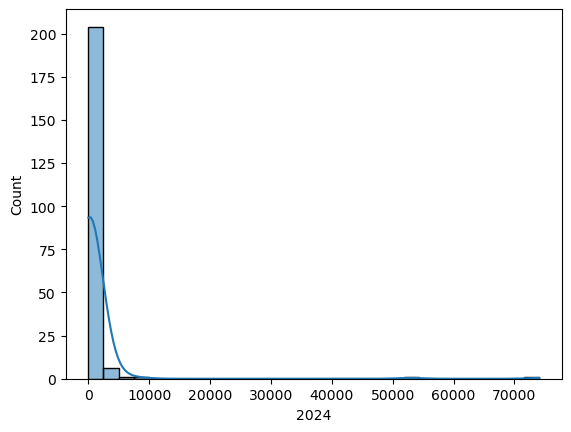

In [7]:
variable = "2024"
pci_df = pci_df[~pci_df[variable].isna()]

sns.histplot(x=pci_df[variable], kde=True);

Veamos el histograma en escala logarítmica para tener una mejor apreciación de los datos:

<Axes: xlabel='2024', ylabel='Count'>

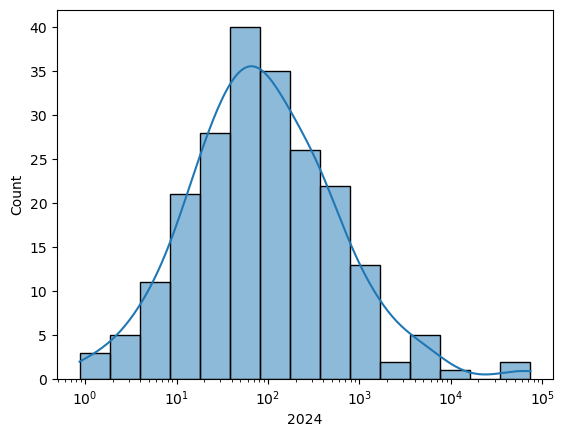

In [8]:
sns.histplot(x=pci_df[variable], kde=True, log_scale=True)


La distribución de ventas por cantón muestra una **cola derecha larga**, indicando que algunos cantones concentran niveles de ventas mucho más altos que el promedio.

Dado que los datos están agregados a nivel cantonal, las conclusiones se aplican a los cantones como unidades, no a empresas o personas individuales, evitando así la **falacia ecológica** (pretender conclusiones a nivel individual con agregaciones).

Gráficos como histogramas o densidades permiten ver la forma general de la distribución, mientras que los **mapas coropléticos** permiten analizar cómo se distribuyen geográficamente las ventas entre cantones.

Antes de generar los mapas, es necesario transformar el sistema de coordenadas (CRS) a una proyección adecuada para el análisis espacial. Para representar correctamente las áreas en **Ecuador**


In [9]:
# Definir proyección Albers Equal Area para Ecuador (personalizada)
crs_ecuador_albers = CRS.from_proj4(
    "+proj=aea +lat_1=-5 +lat_2=2 +lat_0=-2 +lon_0=-78 "
    "+x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)

# Aplicar la transformación
pci_df = pci_df.to_crs(crs_ecuador_albers)

Ahora se genera el mapa coroplético de 2024:ax = pci_df.plot(
    column=variable,
    scheme="Quantiles",
    legend=True,
    edgecolor="none",
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.show()

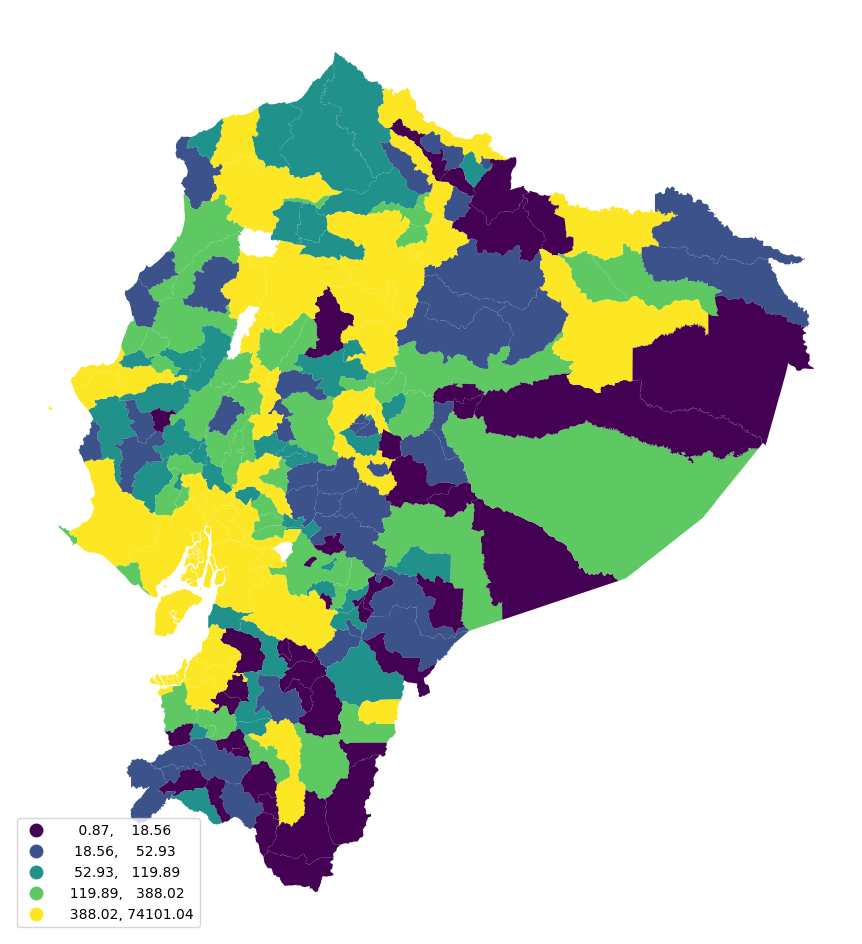

In [10]:
# dci_df[variable] = np.log(dci_df[variable])
ax = pci_df.plot(
    column=variable,
    scheme="Quantiles",
    legend=True,
    edgecolor="none",
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.show()

La densidad kernel muestra la forma estadística de la distribución de ventas por cantón, mientras que el mapa coroplético revela su dimensión geográfica. Ambas son complementarias.

Para medir la desigualdad, se aplican **índices estadísticos** reconocidos en la literatura econométrica.

### Razón 20:20 como medida de desigualdad

Una medida simple y común de desigualdad es la **razón 20:20**, que se calcula dividiendo el valor del percentil 80 entre el del percentil 20. En este caso, representa cuántas veces las ventas más altas (del 20% superior) superan a las más bajas (del 20% inferior).


In [11]:
top20, bottom20 = pci_df[variable].quantile([0.8, 0.2])

In [15]:
print(top20)
print(bottom20)

388.0221425260001
18.563768192


Las variables `top20` y `bottom20` contienen los valtop20 / bottom20 (peores) límite que separan el 20% superior e inferior de la distribución de ventas por cantón. A partir de estos valores, se calcula la **razón 20:20**, dividiendo el valor del percentil 80 entre el del percentil 20.

In [16]:
top20 / bottom20

20.902121730501733

En 2024, el 20% de los cantones con mayores ventas registró un nivel **20,9 veces superior** al del 20% con menores ventas. La **razón 20:20** es una medida útil de desigualdad, ya que es robusta frente a valores extremos en ambos extremos de la distribución.

Para analizar su evolución a lo largo del tiempo, se puede construir una función que calcule este indicador para cada año y representar los resultados como una serie temporal:


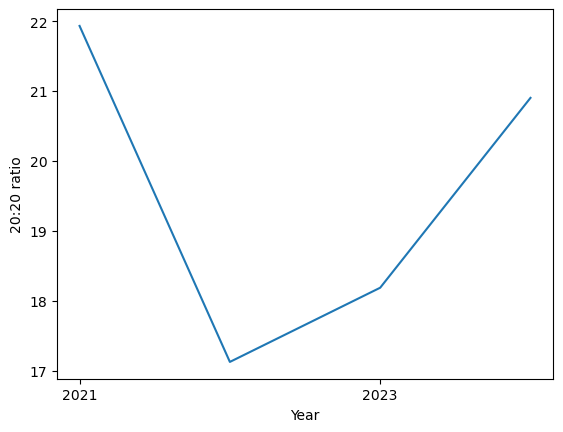

In [17]:
# Define una función para calcular el índice de desigualdad conocido como ratio 20:20
# Este índice compara el quintil superior (80%) con el inferior (20%) de una distribución
# 'values' debe ser una Serie de valores numéricos (como una columna de un DataFrame)
def ineq_20_20(values):
    # Calcula los percentiles 80 (top 20%) y 20 (bottom 20%) de la distribución
    top20, bottom20 = values.quantile([0.8, 0.2])
    # Retorna la razón entre el quintil superior y el inferior (índice de desigualdad)
    return top20 / bottom20


# Genera un arreglo de cadenas de texto representando los años desde 2021 hasta 2024 (inclusive)
# Esto se usa para seleccionar columnas correspondientes a esos años en el DataFrame
years = np.arange(2021, 2025).astype(str)

# Aplica la función 'ineq_20_20' a cada una de las columnas anuales del DataFrame 'pci_df'
# axis=0 indica que la función se aplica columna por columna (por año)
# El resultado es una Serie donde el índice son los años y los valores el índice 20:20 correspondiente
ratio_2020 = pci_df[years].apply(ineq_20_20, axis=0)

# Dibuja la evolución del índice 20:20 en el tiempo utilizando matplotlib
# 'years' como eje X, 'ratio_2020' como eje Y
ax = plt.plot(years, ratio_2020)

# Obtiene la figura actual para manipularla más adelante si es necesario
figure = plt.gcf()

# Ajusta las etiquetas del eje X para que se muestren solo los años alternos
plt.xticks(years[::2])

# Establece la etiqueta vertical (eje Y) indicando que se trata del índice 20:20
plt.ylabel("20:20 ratio")

# Establece la etiqueta horizontal (eje X) indicando que representa el año
plt.xlabel("Year")

# Muestra el gráfico en pantalla
plt.show()


El resultado tiene una forma de U donde resulta interesante asociar intuitivamente una menor concentración en 2022 que fue un año de recuperación económica.


Además de la razón 20:20, se utilizarán dos medidas clásicas de desigualdad: el **índice de Gini** y el **índice de Theil**. Ambos permiten una evaluación más detallada de la dispersión en las ventas por cantón.

Para su cálculo, se usará el paquete `inequality` de **libpysal**, especializado en análisis espacial.


### Índice de Gini

El **índice de Gini** mide la desigualdad comparando la distribución real de ventas con una distribución perfectamente equitativa. Se basa en la **curva de Lorenz**, que muestra la proporción acumulada de ventas en relación con los cantones.

En un escenario igualitario, la curva sería una línea recta. Cuanto más se aleja la curva de esta línea, mayor es la desigualdad.

In [20]:
n = len(pci_df)
share_of_population = np.arange(1, n + 1) / n

Para analizar la desigualdad, se estudia la **evolución acumulada de las ventas**, es decir, qué proporción del total representan distintos grupos de cantones.

Para ello, se ordenan los cantones según su nivel de ventas, y se calcula la proporción acumulada que cada uno aporta al total.


In [21]:
incomes = pci_df[variable].sort_values()

Luego de ordenar los cantones por nivel de ventas, se calcula qué **porcentaje del total de ventas** representa cada uno. Esto permite conocer la **acumulación progresiva** de ventas en la distribución.


In [22]:
shares = incomes / incomes.sum()

Una vez que se calcula qué porcentaje de las ventas totales representa cada cantón, se construye la **suma acumulada** de estas proporciones. Esto permite ver cómo se acumulan las ventas a medida que se agregan los cantones, desde los de menor hasta los de mayor venta.

La fórmula general es:

$$
\text{CumSum}(\mathbf{v}, k) = \sum_{i=1}^{k} v_i
$$

donde $ v_i $ representa la proporción de ventas del cantón $ i $, ordenado de menor a mayor.

Este valor acumulado comienza en 0 y alcanza 1 cuando se han incluido todos los cantones.

In [24]:
cumulative_share = shares.cumsum()

Con esto podemos graficar la curva de Lorenz y la de equidad perfecta:

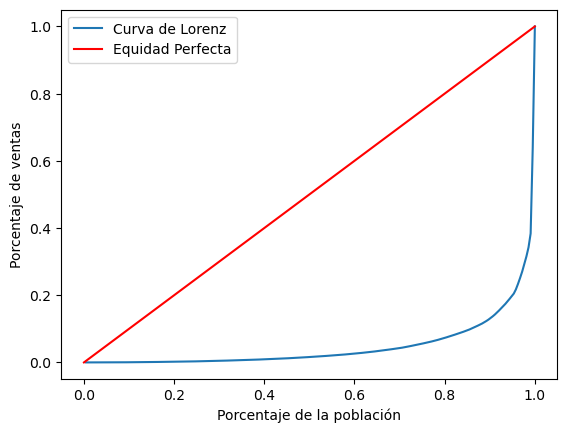

In [25]:
# Crea una figura 'f' y un único eje 'ax' para dibujar el gráfico
# Este es el lienzo sobre el cual se trazará la curva de Lorenz y la línea de equidad
f, ax = plt.subplots()

# Dibuja la Curva de Lorenz sobre el eje 'ax'
# Esta curva representa la desigualdad en la distribución (por ejemplo, de ventas)
# 'share_of_population' debe contener los percentiles acumulados de la población (de 0 a 1)
# 'cumulative_share' debe contener los percentiles acumulados de la variable de interés (ventas, ingresos, etc.)
ax.plot(share_of_population, cumulative_share, label="Curva de Lorenz")

# Dibuja la línea de equidad perfecta (diagonal 45°) que representa igualdad total (p. ej., 10% de la población → 10% de las ventas)
ax.plot((0, 1), (0, 1), color="r", label="Equidad Perfecta")

# Etiqueta del eje X indicando que representa el porcentaje acumulado de la población
ax.set_xlabel("Porcentaje de la población")

# Etiqueta del eje Y indicando que representa el porcentaje acumulado de la variable (ventas, ingresos, etc.)
ax.set_ylabel("Porcentaje de ventas")

# Muestra la leyenda con las etiquetas definidas en los métodos plot (Curva de Lorenz y Equidad Perfecta)
ax.legend()

# Muestra el gráfico generado en pantalla
plt.show()


La **curva de Lorenz** muestra la desigualdad en ventas por cantón, comparada con la línea de igualdad perfecta. El **índice de Gini** es el área entre ambas.

Para analizar su evolución, se puede graficar la curva de Lorenz para cada año con una función en Python.

In [26]:
# Define una función llamada 'lorenz' que toma como entrada un vector de datos (por ejemplo, ingresos o ventas)
def lorenz(y):
    # Convierte la entrada a un array de NumPy, en caso de que venga como lista, Serie de pandas, etc.
    y = np.asarray(y)

    # Ordena los valores en orden ascendente (como se requiere para la curva de Lorenz)
    incomes = np.sort(y)

    # Calcula la proporción acumulada del total (ingresos normalizados)
    # Divide cada ingreso por el total y luego calcula la suma acumulada
    income_shares = (incomes / incomes.sum()).cumsum()

    # Obtiene el número total de observaciones (N)
    N = y.shape[0]

    # Calcula la proporción acumulada de la población
    # Es un vector que va desde 1/N hasta 1, representando la fracción acumulada de la población ordenada
    pop_shares = np.arange(1, N + 1) / N

    # Retorna dos vectores:
    # - pop_shares: eje X de la curva de Lorenz (población acumulada)
    # - income_shares: eje Y de la curva de Lorenz (participación acumulada del ingreso)
    return pop_shares, income_shares


Para un año específico, la función retorna una tupla con dos arrays que conforman los datos para la curva de Lorenz

In [ ]:
# lorenz(pci_df[variable])

Ahora calculamos los valores de la curva de Lorenz para cada año disponible:


In [27]:
lorenz_curves = pci_df[years].apply(lorenz, axis=0)

Se organiza un dataframe con los años como columnas y las proporciones acumuladas como filas. Así, se pueden graficar las curvas de Lorenz para cada año.


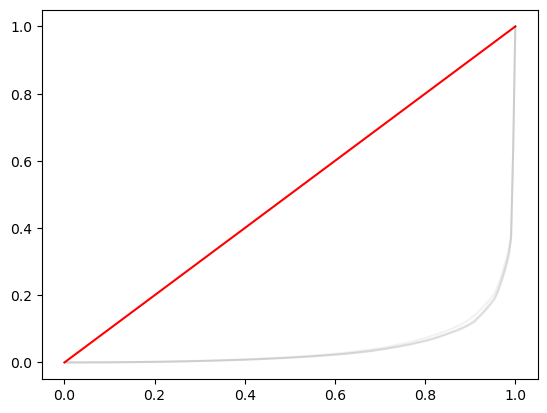

In [28]:
# Crea una figura 'f' y un eje 'ax' para graficar
# Este es el lienzo sobre el cual se dibujarán todas las curvas de Lorenz
f, ax = plt.subplots()

# Dibuja la línea de equidad perfecta (diagonal que representa distribución perfectamente equitativa)
# Va del punto (0,0) al (1,1) en rojo
ax.plot((0, 1), (0, 1), color="r")

# Itera sobre cada columna (año) en el DataFrame 'lorenz_curves'
# Se espera que cada celda contenga una tupla (pop_shares, income_shares) para ese año
for year in lorenz_curves.columns:
    
    # Extrae las proporciones acumuladas de población e ingreso para ese año
    year_pop_shares, year_inc_shares = lorenz_curves[year].values
    
    # Dibuja la curva de Lorenz correspondiente al año actual en color negro con opacidad baja (alpha=0.05)
    # Esto permite superponer muchas curvas sin saturar el gráfico
    ax.plot(year_pop_shares, year_inc_shares, color="k", alpha=0.05)


Comparar curvas de Lorenz puede ser poco claro. En su lugar, el **coeficiente de Gini** resume la desigualdad en un solo valor por año.

Se calcula fácilmente con `inequality.Gini`.

In [29]:
g69 = inequality.gini.Gini(pci_df[variable].values)

Para ver el resultado:

In [30]:
g69.g

np.float64(0.9028045973853324)

En 2024, el **coeficiente de Gini** fue **0,9028**. Para obtener este valor en cada año, se sigue un patrón conocido: definir una función que calcule el Gini, y luego aplicarla a la tabla con todos los años.

In [31]:
# Define una función llamada 'gini_by_col' que calcula el índice de Gini de una columna de datos
# 'column' debe ser una Serie de pandas o un array con valores numéricos (por ejemplo, ingresos, ventas, etc.)
def gini_by_col(column):
    # Usa la clase Gini del módulo inequality.gini para calcular el índice de Gini sobre los valores de la columna
    # Se extrae el atributo .g que representa el valor final del índice de Gini
    return inequality.gini.Gini(column.values).g


`Gini` requiere un `numpy.ndarray`, por eso usamos `.values`. Luego, extraemos solo el valor y lo devolvemos como `DataFrame`.



In [32]:
inequalities = (
    pci_df[years].apply(gini_by_col, axis=0).to_frame("gini")
)

Ahora se tiene el valor para cada año:

In [33]:
inequalities.head()

gini
2021  0.912180
2022  0.911871
2023  0.909600
2024  0.902805

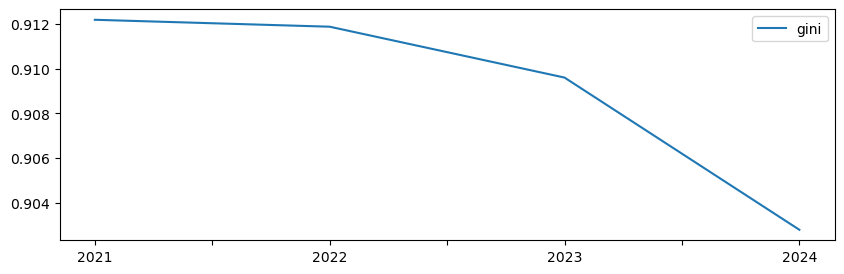

In [35]:
inequalities.plot(figsize=(10, 3));

### Índice de Theil

Otra medida común de desigualdad es el **índice de Theil (T)**, que se basa en la **entropía** de la distribución. Evalúa qué tan equitativamente se distribuyen las ventas entre cantones.

Matemáticamente, compara las ventas de cada cantón con el total nacional, midiendo la distancia respecto a una distribución perfectamente igualitaria.

$$
T = \sum_{i=1}^{m} \left( \frac{y_i}{\sum_{i=1}^{m} y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^{m} y_i} \right] \right)
$$

donde $y_i$ es la venta local por cantón en el área $ i $ entre un total de $ m $ áreas.


Este índice también está disponible en el paquete `inequality` de **libpysal**, por lo que se puede calcular con un enfoque similar al del coeficiente de Gini.


In [39]:
def theil(column):
    return inequality.theil.Theil(column.values).T


inequalities["theil"] = pci_df[years].apply(theil, axis=0)

Ahora si, dame

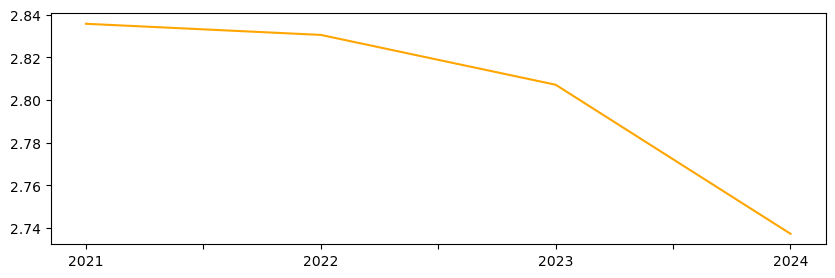

In [40]:
inequalities["theil"].plot(color="orange", figsize=(10, 3));

Aunque Gini y Theil muestran trayectorias similares, **no son equivalentes**. Al compararlos, se evidencia que **capturan diferentes aspectos** de la desigualdad.

Gini y Theil ofrecen **enfoques distintos pero complementarios**.





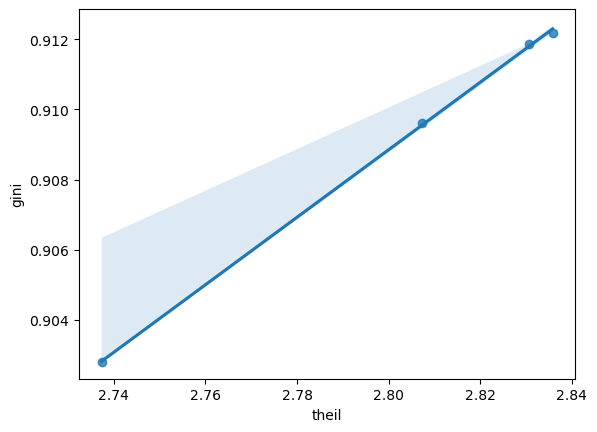

In [38]:
_ = sns.regplot(x="theil", y="gini", data=inequalities)

## Ventas por entidad VS por cantón


Existe una diferencia importante entre analizar la **desigualdad entre individuos (personal)** y entre **regiones (regional)**.

Supongamos que un país tiene $ N $ individuos distribuidos en $ m $ regiones. El ingreso total en una región $ i $ se obtiene sumando los ingresos individuales de sus habitantes. El ingreso per cápita de la región es ese total dividido por el número de personas en la región.

A nivel nacional, la desigualdad interpersonal puede medirse usando el **coeficiente de variación**, que refleja cómo se dispersan los ingresos individuales respecto al promedio nacional:

$$
CV_{\text{nat}} = \sqrt{\frac{1}{N} \sum_{l=1}^{N} (Y_l - \bar{y})^2}
$$

donde $\bar{y} $ es el ingreso per cápita promedio nacional.

El término clave en esta fórmula es la **suma de cuadrados (TSS)**, que cuantifica la variabilidad total entre individuos:

$$
TSS = \sum_{l=1}^{N} (Y_l - \bar{y})^2
$$


La desviación de un individuo respecto al ingreso promedio nacional se puede descomponer así:

$$
\delta_l = (Y_l - y_i) + (y_i - \bar{y})
$$

- El primer término refleja la diferencia entre el ingreso del individuo y el ingreso promedio de su región.
- El segundo término representa la diferencia entre el ingreso promedio regional y el ingreso promedio nacional.

En estudios regionales, como no se suele disponer de datos individuales dentro de cada región, se **asume que todos los individuos dentro de una misma región tienen el mismo ingreso** (es decir, $ Y_l = y_i $). Con esta suposición, el primer término desaparece.

La variabilidad total (TSS) se puede entonces expresar como:

$$
TSS = \sum_{i=1}^{m} N_i (y_i - \bar{y})^2
$$

Esto implica que toda la desigualdad observada proviene de diferencias **entre regiones** (no dentro de ellas).


Bajo la suposición de ingresos iguales dentro de cada región, todos los individuos de una región **contribuyen igual** a la desigualdad nacional, en una magnitud dada por $ (y_i - \bar{y}) $. La contribución total de la región es $ N_i(y_i - \bar{y}) $.

Aunque asumir **desigualdad interna nula** puede parecer restrictivo, permite aislar y analizar la **desigualdad entre regiones**, no entre personas.

Esta estrategia **eleva el análisis** del nivel individual al nivel territorial, al convertir datos micro (por persona o empresa) en datos agregados por unidad espacial (como cantones).


## Desigualdad espacial

A diferencia de la desigualdad interpersonal, la **desigualdad regional** se centra en unidades espaciales (como cantones), lo que permite aprovechar su ubicación geográfica para entender mejor el fenómeno.

En la literatura, existen tres enfoques principales:

1. Analizar la **autocorrelación espacial**.
2. Descomponer índices globales por región.
3. Incorporar el componente espacial en medidas tradicionales.

### Autocorrelación espacial

Este enfoque permite identificar **patrones geográficos** en la distribución de ventas. Evalúa si los cantones con niveles similares de ventas están geográficamente agrupados.

Para ello, se usa una **matriz de pesos espaciales tipo “queen”** y se calcula el **índice de Moran I** para cada año.

In [42]:
wq = weights.Queen.from_dataframe(pci_df,use_index=False)

Siguiendo el mismo patrón de aplicar funciones a cada año, se construye una función que calcule el índice de **Moran I** y su **pseudo valor-p**.

Este valor-p permite determinar si la autocorrelación espacial observada es **estadísticamente significativa**, es decir, si la distribución de ventas por cantón **no es aleatoria** en el espacio.


In [43]:
# Define una función que calcula el índice de Moran (Moran's I) para una variable espacial
# 'y' es un array o Serie con valores numéricos (por ejemplo, ingresos o ventas por unidad geográfica)
# 'w' es una matriz de pesos espaciales (por defecto se asume que es 'wq', un objeto de tipo libpysal.weights)
def moran_by_col(y, w=wq):

    # Calcula el índice de Moran usando la clase Moran de 'esda' (Exploratory Spatial Data Analysis)
    # 'w' define la estructura de vecindad espacial
    mo = esda.Moran(y, w=w)

    # Construye una Serie de pandas con el estadístico de Moran ('I') y su valor p (simulado)
    mo_s = pd.Series(
        {
            "I": mo.I,              # Valor del índice de Moran
            "I-P value": mo.p_sim   # Valor p obtenido por simulación (permuta aleatoria)
        },
    )

    # Devuelve la Serie con los resultados
    return mo_s


En este caso, la función devuelve un objeto `Series`, lo que permite, al usar `.apply()`, generar una **tabla bien estructurada** con los resultados para cada año.

In [44]:
moran_stats = pci_df[years].apply(moran_by_col, axis=0).T

moran_stats.head()

I  I-P value
2021  0.018315      0.042
2022  0.019037      0.046
2023  0.019664      0.036
2024  0.021660      0.039

Para facilitar la comparación, los resultados obtenidos se **añaden a la tabla `inequalities`**.

In [45]:
inequalities = inequalities.join(moran_stats)

Que se puede visualizar:

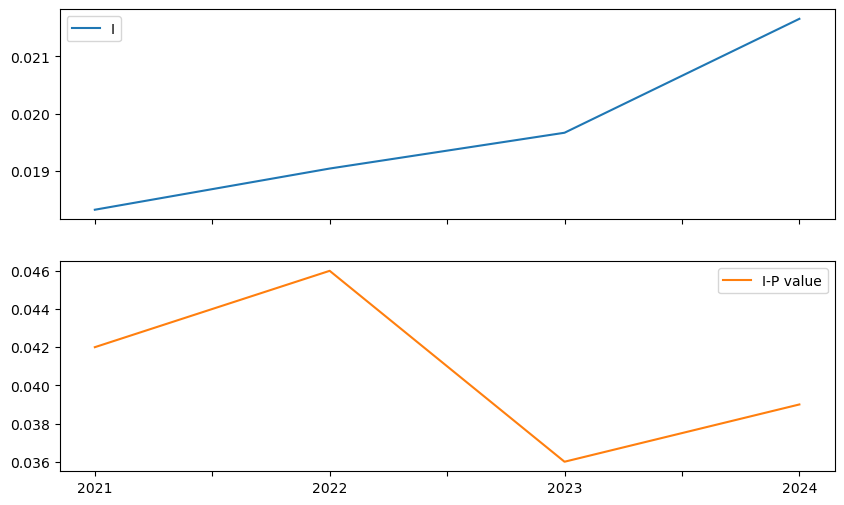

In [46]:
inequalities[["I", "I-P value"]].plot(subplots=True, figsize=(10, 6))
plt.show()

Gini y Theil no siguen trayectorias similares, **Moran I muestra un patrón distinto**: su valor ha aumentado de forma sostenida en el tiempo.

Esto indica un **aumento en la estructura espacial de la desigualdad**, con dos implicaciones:

- (a) Las ventas per cápita entre cantones vecinos son hoy más parecidas.
- (b) Esta tendencia ha sido constante, independientemente del nivel general de desigualdad.

Durante este aumento, **la autocorrelación espacial sigue siendo significativa** todos los años, lo que evidencia una fuerte estructura geográfica en la distribución de ventas.

### Descomposición regional de la desigualdad

Una crítica común al análisis agregado de la desigualdad es que no identifica bien **en qué nivel ocurre**. La desigualdad puede deberse a diferencias entre grupos (por edad, sexo, educación, etc.) más que a diferencias entre individuos similares.

Para abordar esto, es útil **descomponer los índices de desigualdad** en partes:  
- Una que mide desigualdad **entre grupos**.  
- Otra que mide desigualdad **dentro de los grupos**.

En contextos geográficos, los grupos suelen definirse espacialmente (por ejemplo, regiones o cantones). Esta descomposición ayuda a saber **cuánto de la desigualdad total se debe a diferencias territoriales**.

En el ejemplo original, se usan regiones naturales de Ecuador. Aquí podrías aplicar este enfoque a las provincias u otras unidades geográficas del país.

In [48]:
region_names = {
    "01": "Sierra",
    "02": "Sierra",
    "03": "Sierra",
    "04": "Sierra",
    "05": "Sierra",
    "06": "Sierra",
    "07": "Costa",
    "08": "Costa",
    "09": "Costa",
    "10": "Sierra",
    "11": "Sierra",
    "12": "Costa",
    "13": "Costa",
    "14": "Oriente",
    "15": "Oriente",
    "16": "Oriente",
    "17": "Sierra",
    "18": "Sierra",
    "19": "Oriente",
    "21": "Oriente",
    "22": "Oriente",
    "23": "Costa",
    "24": "Costa"
    
}

Podemos **visualizar las regiones** asignando un nombre a cada número de región y luego generando un **mapa coroplético cualitativo**, con los nombres visibles en la leyenda.

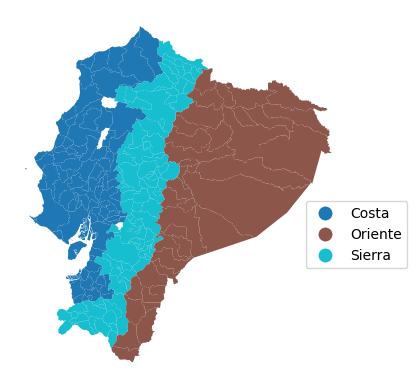

In [49]:
ax = pci_df.assign(Region_Name=pci_df.DPA_PROVIN.map(region_names)).plot(
    "Region_Name",
    linewidth=0,
    legend=True,
    categorical=True,
    legend_kwds=dict(bbox_to_anchor=(1.2, 0.5)),
)
ax.set_axis_off();

Para analizar los **cambios en ventas por región**, se puede usar el patrón **split-apply-combine**:  

1. Agrupar cantones por región,  
2. Calcular el promedio en cada grupo,  
3. Combinar los resultados en una sola tabla.


In [52]:
rmeans = (
    pci_df.assign(
        # Create column with region name for each county
        Region_Name=pci_df.DPA_PROVIN.map(region_names)
    ).groupby(
        # Group counties by region name
        by="Region_Name"
        # Calculate mean by region and save only year columns
    )[years].mean()
)
rmeans

2021         2022         2023         2024
Region_Name                                                   
Costa        938.871580  1075.356479  1128.324392  1138.322542
Oriente       73.637551    86.835610    97.403837   108.034951
Sierra       997.523664  1133.872753  1185.869525  1167.949290

La tabla resultante tiene **una fila por región** y **una columna por año**, con los promedios correspondientes. Al graficarla, podemos visualizar la **trayectoria temporal** de las regiones.


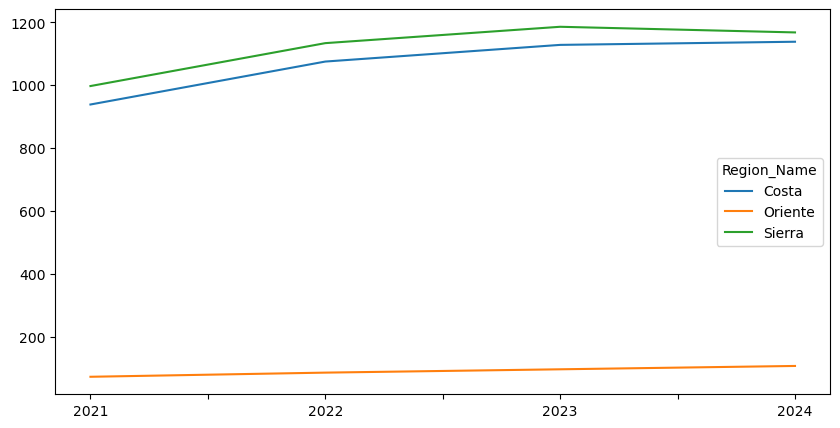

In [51]:
rmeans.T.plot.line(figsize=(10, 5));

Para incorporar la dimensión espacial en el análisis de desigualdad, se puede descomponer el índice de **Theil (T)** en dos componentes:

- **B**: desigualdad **entre regiones** (between),
- **W**: desigualdad **dentro de las regiones** (within).

Esto se logra agrupando las unidades geográficas (cantones, por ejemplo) en regiones mutuamente exclusivas. El índice total se expresa como:

$$
T = B + W
$$

donde:
- $ B $ mide la desigualdad entre regiones usando promedios regionales,
- $ W $ mide la desigualdad interna ponderada según el tamaño de cada región.

Esta descomposición ayuda a entender **qué parte de la desigualdad total se debe a diferencias entre regiones** y **cuánto se debe a desigualdades internas** dentro de cada región.

Una vez comprendido el concepto de descomposición, su implementación técnica es sencilla gracias al paquete `inequality` de **libpysal**, usando la clase `TheilD`.


In [54]:
theil_dr = inequality.theil.TheilD(
    pci_df[years].values, pci_df.DPA_PROVIN
)



El objeto `theil_dr` guarda los componentes de desigualdad:  
- `bg`: desigualdad **entre regiones** (between group)  
- `wg`: desigualdad **dentro de regiones** (within group)

Por ejemplo, para obtener el componente “between” por año, se accede a `theil_dr.bg`.

In [55]:
theil_dr.bg

array([1.07988904, 1.07940704, 1.07288824, 1.05284728])

Como en pasos anteriores, los componentes `bg` y `wg` del índice de TheilD pueden **almacenarse en la tabla de resultados** para facilitar su análisis y comparación.

In [56]:
inequalities["theil_between"] = theil_dr.bg
inequalities["theil_within"] = theil_dr.wg


Aunque se puede hacer **inferencia estadística** sobre la descomposición del índice de Theil usando `inequality.theil.TheilDSim`, aquí solo se reporta que, al igual que con Moran I, **todas las descomposiciones son estadísticamente significativas**.

Dado que los componentes "within" y "between" son **proporciones del índice total de Theil**, es posible calcular qué **porcentaje de la desigualdad total se debe a las diferencias entre regiones**.


In [57]:
inequalities["theil_between_share"] = (
    inequalities["theil_between"] / inequalities["theil"]
)

Veamos las tres series:

gini     theil         I  I-P value  theil_between  theil_within  \
2021  0.912180  2.835770  0.018315      0.042       1.079889      1.755881   
2022  0.911871  2.830554  0.019037      0.046       1.079407      1.751147   
2023  0.909600  2.807201  0.019664      0.036       1.072888      1.734313   
2024  0.902805  2.737357  0.021660      0.039       1.052847      1.684510   

      theil_between_share  
2021             0.380810  
2022             0.381341  
2023             0.382191  
2024             0.384622

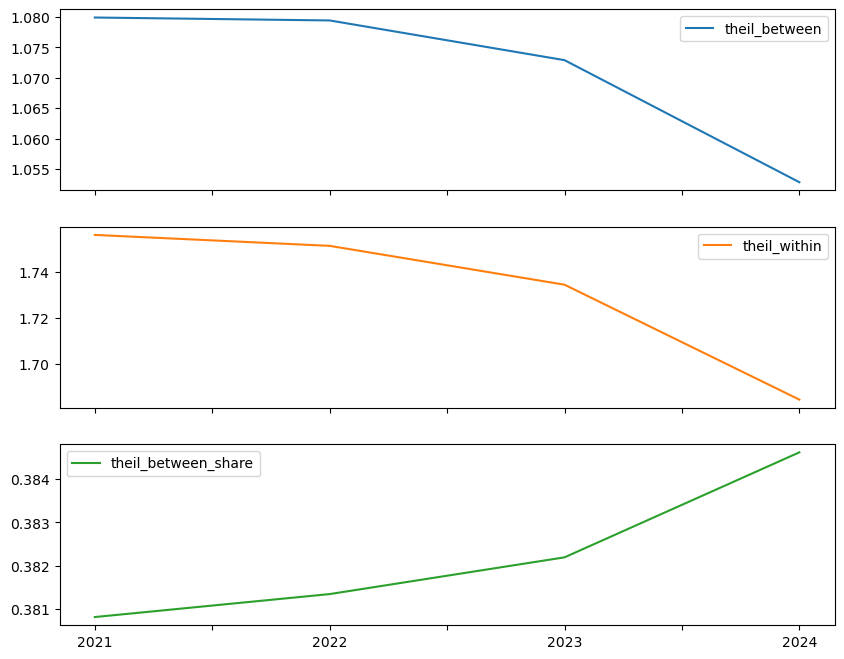

In [59]:
inequalities[
    ["theil_between", "theil_within", "theil_between_share"]
].plot(subplots=True, figsize=(10, 8));

inequalities

### Espacialización de medidas clásicas

Aunque las descomposiciones regionales aportan información valiosa, no capturan todos los aspectos de la desigualdad. Esto se debe a que una "región" es simplemente una forma particular de agrupar observaciones, y no necesariamente una representación explícita del espacio. Es decir, la "geografía" solo se hace visible a través de la pertenencia a un grupo (por ejemplo, ¿el cantón está “dentro” de la región o no?).

Este enfoque basado en el lugar es geográfico, pero **no necesariamente espacial**, ya que no toma en cuenta la **distancia ni la proximidad** entre unidades. En otras palabras, si reorganizamos la ubicación de las regiones en el mapa, los métodos estadísticos tradicionales no cambiarían, siempre que la estructura de agrupamiento se mantenga. Técnicamente, serían las mismas regiones aunque estén en distintos lugares físicos.

El último enfoque que se presenta en el capítulo busca **integrar explícitamente el espacio en una medida tradicionalmente no espacial**. En particular, se propone una **versión espacial del índice de Gini**. Este índice espacial considera cómo la **adyacencia espacial** (es decir, qué tan cerca están las unidades) influye en la desigualdad, lo que permite descomponer el índice tradicional de Gini con base en esta dimensión espacial.

La fórmula del Gini tradicional se puede expresar así, enfocándose en las diferencias absolutas por pares en los ingresos:

$$
G = \frac{\sum_i \sum_j |y_i - y_j|}{2n^2 \bar{y}}
$$

donde:

- $ n $ es el número de observaciones,  
- $ \bar{y} $ es el ingreso promedio.

Este índice se puede descomponer en dos partes:
1. Las diferencias entre observaciones **cercanas**,
2. Las diferencias entre observaciones **distantes**.

Esta es la idea central del **índice de Gini espacial**, que considera explícitamente la ubicación relativa de las unidades.

La descomposición toma una forma similar a la del índice de Theil regional, y se expresa como:

$$
\sum_i \sum_j |y_i - y_j| = \sum_i \sum_j (w_{ij} |y_i - y_j|) + \sum_i \sum_j \left((1 - w_{ij}) |y_i - y_j|\right)
$$

donde:

- $ w_{ij} $ representa el **peso espacial** entre las observaciones $ i $ y $ j $, indicando si son unidades cercanas.

De este modo, se distingue entre desigualdades que ocurren entre vecinos y aquellas que ocurren entre observaciones más alejadas, integrando el espacio en el análisis de desigualdad.




En esta descomposición, $ w_{ij} $ es una variable binaria que vale 1 si las observaciones $ i $ y $ j $ son vecinas, y 0 en caso contrario. Este valor proviene de una **matriz de pesos espaciales**, como las vistas en el Capítulo 4, y se puede aplicar directamente desde dicha matriz.

Así, el **índice de Gini espacial** se puede expresar como:

$$
G = \frac{\sum_i \sum_j w_{ij} |x_i - x_j|}{2n^2 \bar{x}} + \frac{\sum_i \sum_j (1 - w_{ij}) |x_i - x_j|}{2n^2 \bar{x}}
$$

Donde:

- El primer término representa las **diferencias entre observaciones vecinas**,
- El segundo término representa las **diferencias entre observaciones no vecinas**.

En esta formulación, el Gini espacial se interpreta principalmente a partir del **primer componente**, que captura la desigualdad entre unidades geográficamente cercanas.



**Dependencia espacial y desigualdad** 

El Gini espacial permite incorporar la **dependencia espacial** en el análisis de desigualdad. Si esta dependencia es fuerte y positiva, significa que los ingresos entre vecinos son muy similares, por lo que la desigualdad entre unidades “cercanas” será baja. En ese caso, la mayor parte de la desigualdad proviene de las diferencias entre unidades distantes.

En cambio, si la dependencia espacial es débil (o incluso negativa), las dos componentes pueden llegar a igualarse. Para evaluar estadísticamente el Gini espacial, se pueden usar **permutaciones espaciales aleatorias** de los ingresos. Estas pruebas permiten verificar si la estructura observada es diferente a una distribución completamente aleatoria en el espacio.



**Complemento útil a la descomposición regional**

El Gini espacial ofrece una **visión complementaria** a la descomposición regional del índice de Theil:

- La descomposición de Theil no considera relaciones por pares entre observaciones,  
- El Gini espacial **sí** toma en cuenta estas relaciones, lo que lo hace más sensible.

Esto implica que el Gini espacial puede detectar con mayor precisión desigualdades originadas por **pequeños grupos geográficos con ingresos significativamente altos**, algo que las medidas más agregadas podrían pasar por alto.



**Estimación del Gini espacial**

El cálculo del Gini espacial se puede realizar fácilmente utilizando la clase `Gini_Spatial` donde se usa una matriz de pesos espacuiales binaria:



In [60]:
from inequality.gini import Gini_Spatial


wq.transform = "B"

El índice de Gini espacial se puede calcular a partir de un **vector de ventas** y una **matriz de pesos espaciales** que describe la adyacencia entre las observaciones.


In [61]:
gs69 = Gini_Spatial(pci_df[variable], wq)

El Gini espacial se guarda en el atributo `g` igual que en el caso no espacial

In [62]:
gs69.g

np.float64(0.9028045973853324)

La proporción del **índice de Gini espacial** que corresponde a las **diferencias entre observaciones lejanas** se guarda en el atributo `wcg_share`.

In [63]:
gs69.wcg_share

np.float64(0.8630524531476716)

El **valor-p** de esta prueba evalúa si la desigualdad entre **observaciones vecinas** es mayor (o menor) que la que se esperaría si las **ventas se distribuyeran aleatoriamente** en el mapa.

In [64]:
gs69.p_sim

np.float64(0.01)

El valor obtenido para 2024 es **estadísticamente significativo**, lo que indica que la desigualdad entre cantones vecinos **difiere** de la desigualdad entre cantones no vecinos.

Podemos extender este análisis a todos los años de la muestra utilizando el enfoque **función por columna**. En este caso, se desea obtener:

- El valor del **índice de Gini espacial**,
- La **descomposición** entre vecinos y no vecinos,
- Y los **valores-p simulados** (pseudo-p) para evaluar la significancia.

In [65]:
def gini_spatial_by_col(incomes, weights):
    gs = Gini_Spatial(incomes, weights)
    denom = 2 * incomes.mean() * weights.n ** 2
    near_diffs = gs.wg / denom
    far_diffs = gs.wcg / denom
    out = pd.Series(
        {
            "gini": gs.g,
            "near_diffs": near_diffs,
            "far_diffs": far_diffs,
            "p_sim": gs.p_sim,
        }
    )
    return out



La **inferencia estadística** sobre el Gini espacial es **computacionalmente exigente**, ya que en cada permutación deben recalcularse todas las diferencias por pares entre observaciones.

Por ello, este tipo de análisis puede tardar en ejecutarse.

In [66]:
spatial_gini_results = (
    pci_df[years].apply(gini_spatial_by_col, weights=wq).T
)

In [69]:
spatial_gini_results.head()

gini  near_diffs  far_diffs  p_sim
2021  0.912180    0.040669   0.871511   0.01
2022  0.911871    0.040569   0.871302   0.01
2023  0.909600    0.040348   0.869251   0.01
2024  0.902805    0.039752   0.863052   0.01

Los **valores-p** obtenidos son consistentemente **pequeños**, lo que sugiere que la contribución de los vínculos locales (cantones vecinos) a la desigualdad es **menor de lo que se esperaría** si las ventas estuvieran distribuidas aleatoriamente en el territorio.

Para evaluar esto sistemáticamente, se puede calcular el **porcentaje de veces** que el valor-p es menor que un umbral (por ejemplo, 0.05), utilizando el promedio (`mean`).


In [70]:
(spatial_gini_results.p_sim < 0.05).mean()

np.float64(1.0)

La **desigualdad entre unidades vecinas** es alta pese a:

1. Los pares de observaciones **cercanas** representan **menos del 3%** (2.493%) de todos los pares posibles.


In [71]:
wq.pct_nonzero

2.4936675692200194

2. Cuando existe una **fuerte dependencia espacial**, las observaciones cercanas tienden a ser **muy similares**, por lo que sus diferencias también son pequeñas. Como resultado, al sumar pocas diferencias y de baja magnitud, el total del componente "vecino" resulta bajo en comparación con las diferencias entre unidades lejanas.

Por lo tanto, un **valor pequeño del componente entre vecinos es en realidad indicativo de dependencia espacial**.

De hecho, como se observa, a medida que la dependencia espacial aumenta, las diferencias entre vecinos (**near_diffs**) disminuye.

array([<Axes: >, <Axes: >], dtype=object)

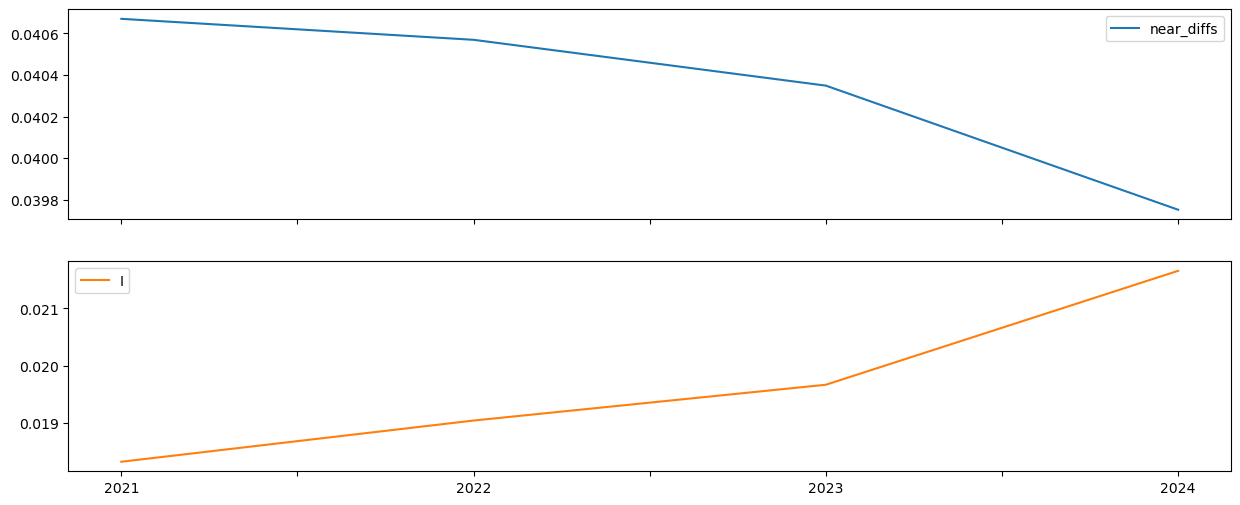

In [72]:
inequalities["near_diffs"] = spatial_gini_results.near_diffs

inequalities[["near_diffs", "I"]].plot.line(
    subplots=True, figsize=(15, 6)
)

## Preguntas

1. ¿Por qué es importante el estudio de la desigualdad de ingresos regional? ¿En qué se diferencia el estudio de la desigualdad regional de ingresos respecto al de la desigualdad de ingresos personales?

2. Dado que las estadísticas de Theil y Gini parecen seguir trayectorias temporales diferentes, ¿por qué un investigador elegiría usar ambas medidas al analizar la dinámica de las disparidades regionales? ¿Por qué no usar solo una u otra?

3. ¿Qué aspectos de la distribución regional de ingresos no son capturados por el coeficiente de Theil o el de Gini? ¿Por qué son importantes estas omisiones y qué enfoques podrían utilizarse para abordar estas limitaciones?

4. ¿Cómo podría verse afectada la medición de la desigualdad de ventas locales entre regiones por la elección del esquema de regionalización (es decir, cómo se agrupan las diferentes unidades espaciales para formar regiones)?

5. ¿Cuál es la relación entre la desigualdad espacial de ventas locales y la dependencia espacial de las ventas locales regionales?
